## Task 3: Transfer Learning

In [2]:
import numpy as np
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import itertools
import math

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, test_data_Pipeline_non_normalized
from funcs_Task2_3 import plot_accuracy_loss, concat_generators, plot_confusion_matrix

In [6]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs=30


### 1. Classification Set-Up

In [3]:
np.random.seed(123)
tf.random.set_seed(123) 
metrics = ["accuracy"]

### 2. Setting Up the Base Model

In [4]:
# instantiate pre-trained model and freeze layers
ResNet_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
)

ResNet_model.trainable = False

2025-05-03 15:46:42.658020: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-03 15:46:42.658075: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: nixos
2025-05-03 15:46:42.658092: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: nixos
2025-05-03 15:46:42.658217: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-05-03 15:46:42.658269: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 565.77.0


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [5]:
# add extra layers to model
inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

# print architecture
model.summary(show_trainable = True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50v2 (Functional)     │ (None, 4, 4, 2048)    │ 23,564,800 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 128)           │    262,272 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### 3. Model Training

In [6]:
# compile model and fetch training and validation data
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir = val_dir, train_dir = train_dir)

total_train=train_data_gen.samples
total_val = val_data_gen.samples

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [7]:
# train model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
)

/home/hans/Test/Project-AI-main/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-05-03 15:47:17.629156: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2025-05-03 15:47:17.641955: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27580416 exceeds 10% of free system memory.
2025-05-03 15:47:17.647401: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-05-03 15:47:17.694816: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142737408 exceeds 10% of free system memory.
2025-05-03 15:47:17.716098: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6299 - loss: 1.0654 - val_accuracy: 0.6750 - val_loss: 0.8043
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7278 - loss: 0.6194 - val_accuracy: 0.7050 - val_loss: 0.5611
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7936 - loss: 0.4490 - val_accuracy: 0.6875 - val_loss: 0.5933
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7909 - loss: 0.4134 - val_accuracy: 0.7400 - val_loss: 0.5472
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8278 - loss: 0.3722 - val_accuracy: 0.7425 - val_loss: 0.5381
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8367 - loss: 0.3689 - val_accuracy: 0.7400 - val_loss: 0.5462
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8387 - loss: 0.3509 - val_accuracy: 0.7475 - val_loss: 0.5232
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8481 - loss: 0.3267 - val_accuracy: 0.7750 - val_loss: 0.5038
Epo

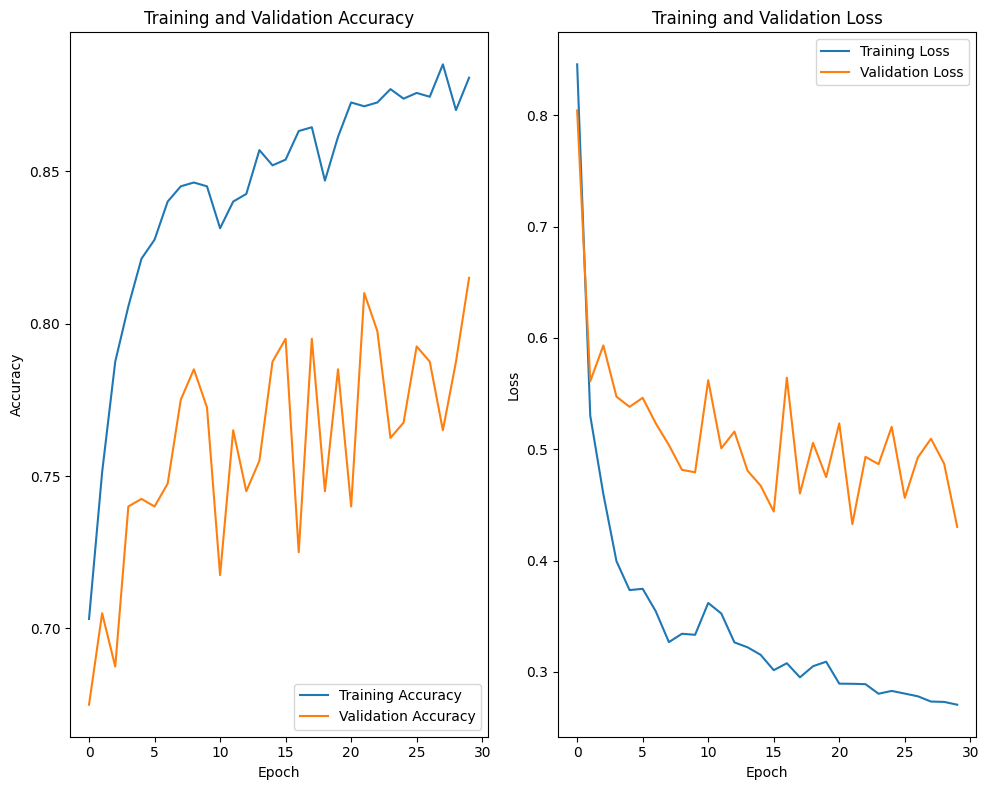

In [8]:
plot_accuracy_loss(history, epochs)

### 4. Hyperparameter Tuning

In [9]:
tf.config.run_functions_eagerly(True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tf.config.run_functions_eagerly(False)

In [10]:
def build_transfer_model(img_height, img_width, dr, lr, metrics, trainingResNet = False):
    inputs = Input(shape=(img_height, img_width, 3))
    x = ResNet_model(inputs, training = trainingResNet)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dr)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(
        inputs,
        outputs
    )

    optimizer = keras.optimizers.Adam(learning_rate = lr)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

    return model

In [ ]:
# Loop over different combinations of hyperparameters
batch_sizes = [32, 64, 128]
learning_rates = [1e-2, 1e-3, 1e-4]
dropout_rates = [0.3, 0.4, 0.5]

results = []

for comb in itertools.product(batch_sizes, dropout_rates, learning_rates):
    batch_size = comb[0]
    dr = comb[1]
    lr = comb[2] 
    print(f'Start with batch size: {batch_size}, learning rate: {lr}, dropout rate: {dr}')

    model = build_transfer_model(img_height, img_width, dr, lr, metrics, trainingResNet = False)

    # Train model
    history = model.fit(
        train_data_gen,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        callbacks = [early_stop],
        verbose = 0
    )

    # Collect results
    best_val_acc = max(history.history['val_accuracy'])
    amount_epochs = max(history.epoch)
    results.append({
        'batch_size': batch_size,
        'learning_rate': lr,
        'dropout_rate': dr,
        'val_accuracy': best_val_acc,
        'epochs': amount_epochs
    })

    print(f"Done: batch_size={batch_size}, lr={lr}, dr={dr}, val_acc={best_val_acc:.4f}, epochs={amount_epochs}")


df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task3_grid.csv", index=False)


Start with batch size: 32, learning rate: 0.01, dropout rate: 0.3
Done: batch_size=32, lr=0.01, dr=0.3, val_acc=0.7450, epochs=15
Start with batch size: 32, learning rate: 0.001, dropout rate: 0.3
Done: batch_size=32, lr=0.001, dr=0.3, val_acc=0.8050, epochs=29
Start with batch size: 32, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=32, lr=0.0001, dr=0.3, val_acc=0.7550, epochs=29
Start with batch size: 32, learning rate: 0.01, dropout rate: 0.4
Done: batch_size=32, lr=0.01, dr=0.4, val_acc=0.7525, epochs=19
Start with batch size: 32, learning rate: 0.001, dropout rate: 0.4
Done: batch_size=32, lr=0.001, dr=0.4, val_acc=0.7325, epochs=7
Start with batch size: 32, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=32, lr=0.0001, dr=0.4, val_acc=0.7500, epochs=29
Start with batch size: 32, learning rate: 0.01, dropout rate: 0.5
Done: batch_size=32, lr=0.01, dr=0.5, val_acc=0.7700, epochs=20
Start with batch size: 32, learning rate: 0.001, dropout rate: 0.5
Done: batch_

### 5. Train your pre-trained model

In [12]:
# get data generators and specify hyperparameters (best performing from tuning)
training_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

total_train = train_data_gen.samples + val_data_gen.samples

best_run = df[df.val_accuracy == df.val_accuracy.max()]
learning_rate = best_run.learning_rate.iloc[0]
dropout_rate = best_run.dropout_rate.iloc[0]
batch_size = best_run.batch_size.iloc[0]
epochs = best_run.epochs.iloc[0]
best_val_acc = best_run.val_accuracy.iloc[0]

print(f"Best performing hyperparameters: batch size = {batch_size}, dropout rate = {dropout_rate}, learning rate = {learning_rate}, epochs ran = {amount_epochs}, val_acc={best_val_acc:.4f}")

Found 1600 images belonging to 2 classes.


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Best performing hyperparameters: batch size = 64, dropout rate = 0.3, learning rate = 0.001, epochs ran = 29, val_acc=0.8125


In [13]:
# train transfer model
transfer_model = build_transfer_model(
    img_height, img_width, 
    dropout_rate, learning_rate, 
    metrics, trainingResNet = False
)

history = transfer_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch= math.ceil(total_train / batch_size),
    epochs=epochs
)

Epoch 1/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6235 - loss: 1.5031
Epoch 2/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7719 - loss: 0.4671
Epoch 3/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8041 - loss: 0.3967
Epoch 4/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8239 - loss: 0.3713
Epoch 5/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8214 - loss: 0.3751
Epoch 6/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8311 - loss: 0.3553
Epoch 7/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8340 - loss: 0.3580
Epoch 8/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8467 - loss: 0.3329
Epoch 9/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8562 - loss: 0.3161
Epoch 10/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8481 - loss: 0.3194
Epoch 11/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8519 - loss: 0.3169
Epoch 12/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8596 - lo

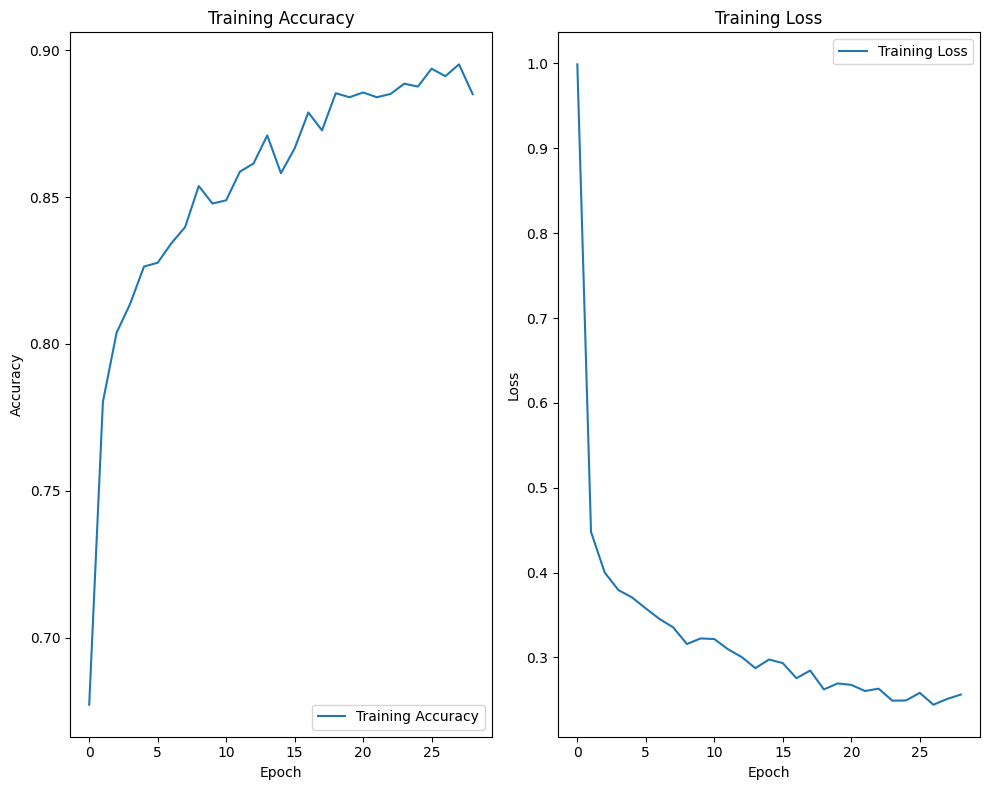

In [14]:
plot_accuracy_loss(history, epochs, validation = False)

In [15]:
model.save("ResNet_model.keras")
loaded_model = load_model("ResNet_model.keras")

### 6. Fine-tuning of the entire model

In [16]:
# retrain model with unfrozen ResNet part
loaded_model.get_layer("resnet50v2").trainable = True
loaded_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics= metrics)

history = loaded_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch= math.ceil(total_train / batch_size),
    epochs=epochs
)
model.save("ResNet_finetuned_model.keras")

Epoch 1/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.8363 - loss: 0.3648
Epoch 2/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - accuracy: 0.9437 - loss: 0.1515
Epoch 3/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.9595 - loss: 0.1237
Epoch 4/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.9692 - loss: 0.0881
Epoch 5/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.9499 - loss: 0.1604
Epoch 6/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.9726 - loss: 0.0759
Epoch 7/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 186s 6s/step - accuracy: 0.9808 - loss: 0.0523
Epoch 8/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.9697 - loss: 0.0861
Epoch 9/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 186s 6s/step - accuracy: 0.9706 - loss: 0.0727
Epoch 10/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.9801 - loss: 0.0560
Epoch 11/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.9785 - loss: 0.0583
Epoch 12/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy:

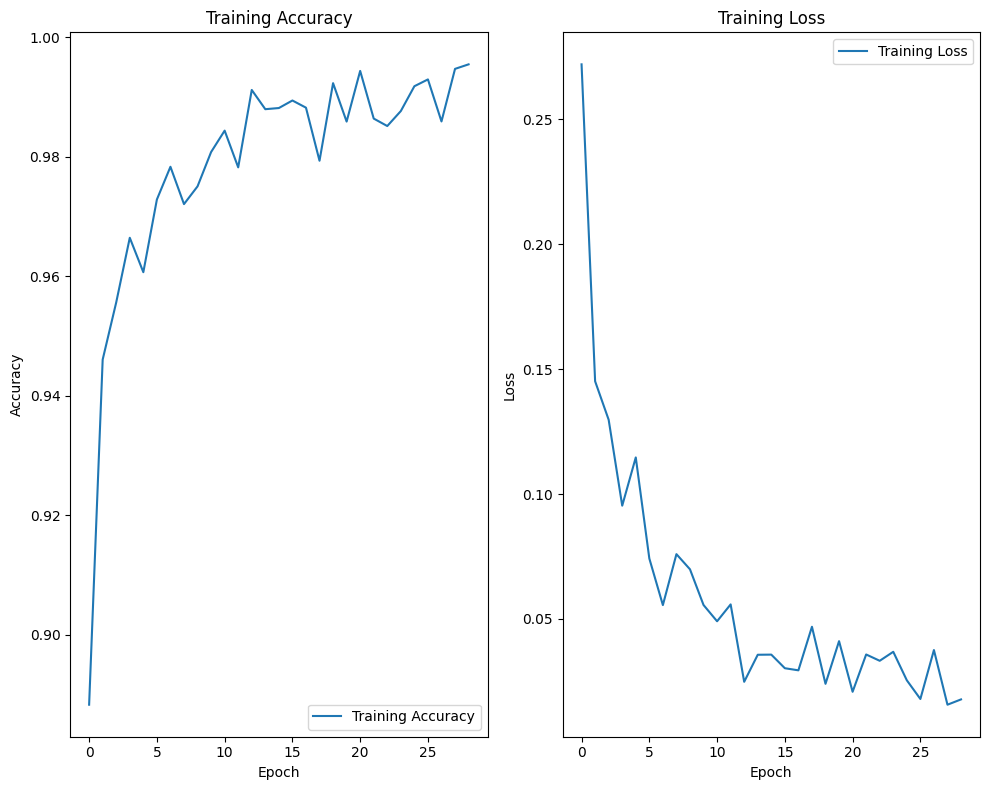

In [17]:
plot_accuracy_loss(history, epochs, validation = False)

In [3]:
final_model = load_model("ResNet_finetuned_model.keras")

In [ ]:
## evaluate model based on test data
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle=False)
loss, accuracy = final_model.evaluate(test_data_gen)

y_true = test_data_gen.classes
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred, target_names=test_data_gen.class_indices.keys()))

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - accuracy: 0.7296 - loss: 0.5509
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  
Test Loss: 0.5282
Test Accuracy: 0.7550
              precision    recall  f1-score   support

       COVID       0.78      0.71      0.74       100
      NORMAL       0.73      0.80      0.77       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.75       200



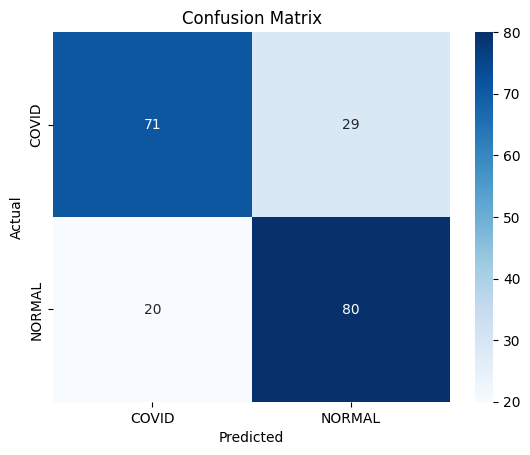

In [8]:
plot_confusion_matrix(y_true, y_pred, test_data_gen)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step
Found 200 images belonging to 2 classes.


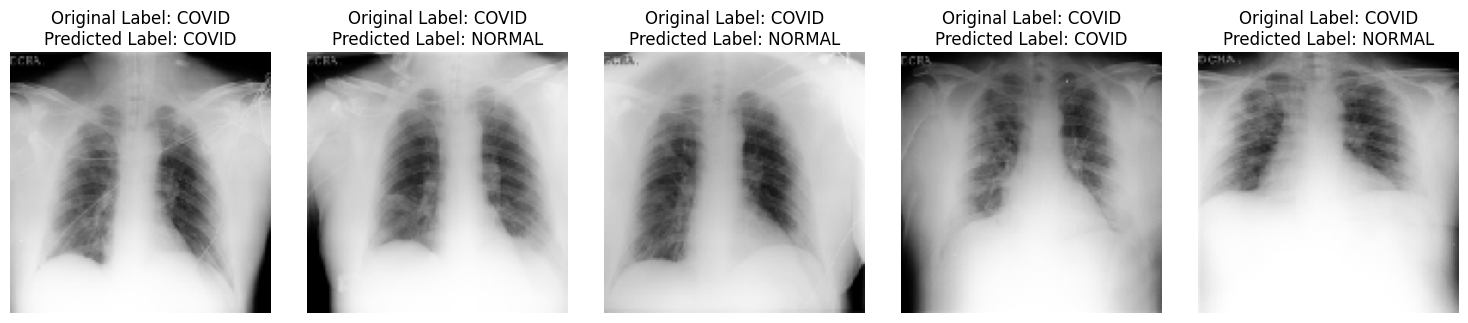

In [21]:
# Plot a few samples from the test dataset without normalization with evaluation (after normalization)
# Get batch and process
## normalized 
test_data_gen_normalized  = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
sample_images_normalized, sample_labels_normalized  = next(test_data_gen_normalized)

## non-normalized 
test_data_gen_non_normalized = test_data_Pipeline_non_normalized(batch_size, img_size, test_dir)
sample_images_non_normalized, sample_labels_non_normalized =  next(test_data_gen_non_normalized)

class_names = list(test_data_gen.class_indices.keys())

plt.figure(figsize=(15, 6))
for i, (img, label, pred) in enumerate(zip(sample_images_non_normalized[:5], sample_labels_non_normalized[:5], y_pred[:5])):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original Label: {class_names[int(label)]}\nPredicted Label: {class_names[pred]}"), plt.axis('off')
    
plt.tight_layout()
plt.show()